# Import Vari

In [ ]:
!pip install transformers
!pip install tslearn
!pip install pyyaml==5.4.1

     |████████████████████████████████| 3.5 MB 8.5 MB/s 
     |████████████████████████████████| 596 kB 33.2 MB/s 
     |████████████████████████████████| 895 kB 38.7 MB/s 
     |████████████████████████████████| 67 kB 3.5 MB/s 
     |████████████████████████████████| 6.8 MB 20.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 793 kB 5.6 MB/s 
     |████████████████████████████████| 636 kB 8.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [ ]:
import torch
from torch import nn  

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

import numpy as np
import pandas as pd

from scipy import stats

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("neuraly/bert-base-italian-cased-sentiment")

# Load the model, use .cuda() to load it on the GPU
model = AutoModelForSequenceClassification.from_pretrained("neuraly/bert-base-italian-cased-sentiment")

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)

Using PyTorch version: 1.10.0+cu111 Device: cpu 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/My Drive/Text Analytics/Data/'

Mounted at /content/drive


In [ ]:
# load corpus
df = pd.read_json(directory+'df_final.json')

# missing values
df['Text'].replace('', np.nan, inplace=True)
df.dropna(subset = ["Text"], inplace=True)

df.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3
8,917635,Hawthorn and Unicorn Air,giallo,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4


Discretizing the Popularity variable

In [ ]:
df['Popularity'] = df['N_Rev']

col         = 'Popularity'
conditions  = [ df[col] >= 6, (df[col] < 6) & (df[col] > 2), df[col] <= 2]
choices     = [ "popular", 'medium', 'unpopular' ] 
    
df[col] = np.select(conditions, choices, default=np.nan)

df.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev,Popularity
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3,medium
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0,unpopular
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2,unpopular
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3,medium
8,917635,Hawthorn and Unicorn Air,giallo,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4,medium


# Crea Subsample per Analisi (df_sentiment)

In [ ]:
df['N_Sent'] = df['Text'].apply(lambda text: len(nltk.sent_tokenize(text))) # counting sentences per fan-fiction
df.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev,Popularity,N_Sent
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3,medium,106
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0,unpopular,92
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2,unpopular,22
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3,medium,56
8,917635,Hawthorn and Unicorn Air,giallo,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4,medium,58


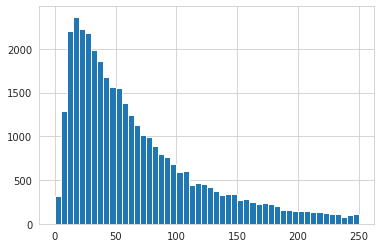

In [ ]:
sns.set_style('whitegrid')
df['N_Sent'].hist(range=(0,250), bins=50)

In [ ]:
sample_df = df[(df['N_Sent']>=20) & (df['N_Sent']<=25)]
sample_df.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev,Popularity,N_Sent
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2,unpopular,22
13,80,Semplicemente..grazie.,verde,Kiara,2003-06-21 00:00:00+00:00,1,Semplicemente Semplicemente..grazie...,27,popular,25
17,706259,Mille papaveri rossi.,verde,Hayley Black,2011-01-05 00:00:00+00:00,1,Mille papaveri rossi. Dormi sepolto in ...,8,popular,21
34,719014,Heartbreak,giallo,Emily Kingston,2011-05-20 00:00:00+00:00,1,"Heartbreak Tic, toc. Tic, toc. Il tu...",4,medium,21
38,719165,Un amore felino,verde,WhitePumpkin,2011-05-20 00:00:00+00:00,1,"Mrs Purr correva per i corridoi di Hogwarts, g...",3,medium,24


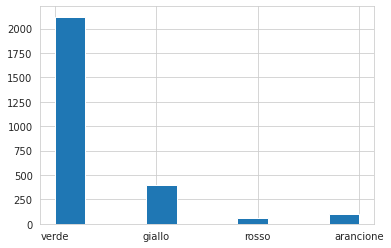

In [ ]:
sample_df.Rating.hist()

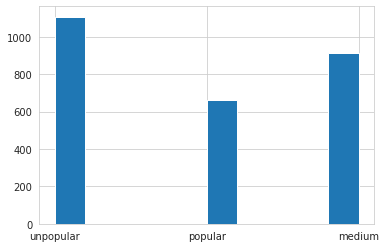

In [ ]:
sample_df.Popularity.hist()

# Sentiment Analysis

In [ ]:
def analyze_story(text):

    ts = []
    
    #SET MAXIMUM SENTENCE LENGTH!
    sentences = [s[:512] for s in nltk.sent_tokenize(text)]
    
    neg, neu, pos = 0, 0, 0
    
    for sentence in sentences:
        input_ids = tokenizer.encode(sentence, add_special_tokens=True)
        # Create tensor, use .cuda() to transfer the tensor to GPU
        tensor = torch.tensor(input_ids).long()
        # Fake batch dimension
        tensor = tensor.unsqueeze(0)
        # Call the model and get the logits
        logits = model(tensor).logits
        # Remove the fake batch dimension
        logits = logits.squeeze(0)
        # The model was trained with a Log Likelyhood + Softmax combined loss, hence to extract probabilities we need a softmax on top of the logits tensor
        proba = nn.functional.softmax(logits, dim=0)
        # Unpack the tensor to obtain negative, neutral and positive probabilities
        negative, neutral, positive = proba

        neg_val = negative.item()
        neu_val = neutral.item()
        pos_val = positive.item()

        neg += neg_val
        neu += neu_val
        pos += pos_val
        
        if (neg_val > pos_val) and (neg_val > neu_val):
          ts.append((-1)*neg_val)
        elif (neu_val > pos_val):
          ts.append(0)
        else:
          ts.append(pos_val)

    if len(sentences) > 0:
      neg = neg / len(sentences)
      neu = neu / len(sentences)
      pos = pos / len(sentences)
    else:
      neg = 0
      neu = 0
      pos = 0

    return neg, neu, pos, ts

def analyze_df(df, text_col):
    df['NEG'], df['NEU'], df['POS'], df['TS'] = zip(*df[text_col].apply(lambda row: analyze_story(row)))
    df['SentimentScore'] = df['TS'].apply(lambda ts: sum(ts)/sum([1 if x!=0 else 0 for x in ts]))
    df['Sentiment_all_Label'] = df[['NEG', 'NEU', 'POS']].idxmax(axis=1)
    df['SentimentLabel'] = df[['NEG', 'POS']].idxmax(axis=1)
    return df

In [ ]:
#df_sentiment = analyze_df(sample_df, 'Text')
#df_sentiment.to_pickle(directory+'ts_df_final.pkl')

In [ ]:
df_sentiment = pd.read_pickle(directory+'ts_df_final.pkl') #ts_dfFINAL
df_sentiment.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev,Popularity,N_Sent,NEG,NEU,POS,TS,SentimentScore,Sentiment_all_Label,SentimentLabel
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2,unpopular,22,0.162070,0.608198,0.229732,"[0.9713982939720154, 0.9767780303955078, 0, 0,...",0.121957,NEU,POS
13,80,Semplicemente..grazie.,verde,Kiara,2003-06-21 00:00:00+00:00,1,Semplicemente Semplicemente..grazie...,27,popular,25,0.172455,0.228245,0.599299,"[0.996743381023407, -0.7327921390533447, -0.90...",0.491524,POS,POS
17,706259,Mille papaveri rossi.,verde,Hayley Black,2011-01-05 00:00:00+00:00,1,Mille papaveri rossi. Dormi sepolto in ...,8,popular,21,0.008830,0.640014,0.351155,"[0, 0, 0.9532520771026611, 0, 0, 0.98109197616...",0.939167,NEU,POS
34,719014,Heartbreak,giallo,Emily Kingston,2011-05-20 00:00:00+00:00,1,"Heartbreak Tic, toc. Tic, toc. Il tu...",4,medium,21,0.104023,0.715358,0.180619,"[0, 0, 0, 0.9852012991905212, -0.9942978024482...",0.255418,NEU,POS
38,719165,Un amore felino,verde,WhitePumpkin,2011-05-20 00:00:00+00:00,1,"Mrs Purr correva per i corridoi di Hogwarts, g...",3,medium,24,0.113136,0.730927,0.155936,"[0, 0, 0, -0.9707689881324768, -0.679548442363...",0.059188,NEU,POS


In [ ]:
df_sentiment['N_Rating'] = df_sentiment['Rating']
df_sentiment['N_Rating'].replace({'verde': 0, 'giallo': 1, 'arancione': 2, 'rosso': 3}, inplace=True)

df_sentiment.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev,Popularity,N_Sent,NEG,NEU,POS,TS,SentimentScore,Sentiment_all_Label,SentimentLabel,N_Rating
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2,unpopular,22,0.162070,0.608198,0.229732,"[0.9713982939720154, 0.9767780303955078, 0, 0,...",0.121957,NEU,POS,0
13,80,Semplicemente..grazie.,verde,Kiara,2003-06-21 00:00:00+00:00,1,Semplicemente Semplicemente..grazie...,27,popular,25,0.172455,0.228245,0.599299,"[0.996743381023407, -0.7327921390533447, -0.90...",0.491524,POS,POS,0
17,706259,Mille papaveri rossi.,verde,Hayley Black,2011-01-05 00:00:00+00:00,1,Mille papaveri rossi. Dormi sepolto in ...,8,popular,21,0.008830,0.640014,0.351155,"[0, 0, 0.9532520771026611, 0, 0, 0.98109197616...",0.939167,NEU,POS,0
34,719014,Heartbreak,giallo,Emily Kingston,2011-05-20 00:00:00+00:00,1,"Heartbreak Tic, toc. Tic, toc. Il tu...",4,medium,21,0.104023,0.715358,0.180619,"[0, 0, 0, 0.9852012991905212, -0.9942978024482...",0.255418,NEU,POS,1
38,719165,Un amore felino,verde,WhitePumpkin,2011-05-20 00:00:00+00:00,1,"Mrs Purr correva per i corridoi di Hogwarts, g...",3,medium,24,0.113136,0.730927,0.155936,"[0, 0, 0, -0.9707689881324768, -0.679548442363...",0.059188,NEU,POS,0


## Analisi distribuzione sentiment (neg, neu, pos, sentimentScore, sentimentLabel)

In [ ]:
fig = px.scatter(df_sentiment, 
                 x="SentimentLabel", 
                 y="SentimentScore", 
                 color='SentimentScore')
fig.update_layout(
    title_text='Distribution of SentimentLabel and SentimentScore', 
    xaxis_title_text='', # xaxis label
    #yaxis_title_text='Count', # yaxis label
    bargap = 0.1, # gap between bars of adjacent location coordinates
    bargroupgap = 0.1, # gap between bars of the same location coordinates
    width=500, height=400,
    legend = dict(
      orientation="h",
      yanchor="top",
      xanchor="right",
      x=1
    )
)
fig.show()

In [ ]:
stats.spearmanr(df_sentiment['SentimentScore'], df_sentiment['SentimentLabel'])

SpearmanrResult(correlation=0.6896598437933599, pvalue=0.0)

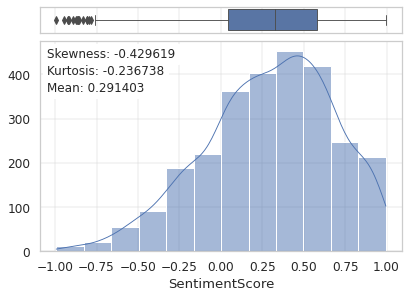

In [ ]:
sns.set(rc={'figure.figsize':(6.5,4.5), "lines.linewidth": 0.9, "grid.linewidth": 0.4}, font_scale=1.1)
sns.set_style("whitegrid")

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.10, .80)})
f.subplots_adjust(hspace=.07)

# Add a graph in each part
sns.boxplot(x='SentimentScore', data=df_sentiment, color="b", ax=ax_box)
fig = sns.histplot(x='SentimentScore', data=df_sentiment, color="b", bins=12, kde=True, ax=ax_hist)

# Add text
fig.text(x=0.02, y=0.97, transform=fig.transAxes, s="Skewness: %f" % df_sentiment['SentimentScore'].skew(),\
        fontsize=12, verticalalignment='top', horizontalalignment='left',\
        backgroundcolor='white')
fig.text(x=0.02, y=0.89, transform=fig.transAxes, s="Kurtosis: %f" % df_sentiment['SentimentScore'].kurt(),\
        fontsize=12, verticalalignment='top', horizontalalignment='left',\
        backgroundcolor='white')
fig.text(x=0.02, y=0.81, transform=fig.transAxes, s="Mean: %f" % df_sentiment['SentimentScore'].mean(),\
        fontsize=12, verticalalignment='top', horizontalalignment='left',\
        backgroundcolor='white')
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(ylabel='')

plt.show()

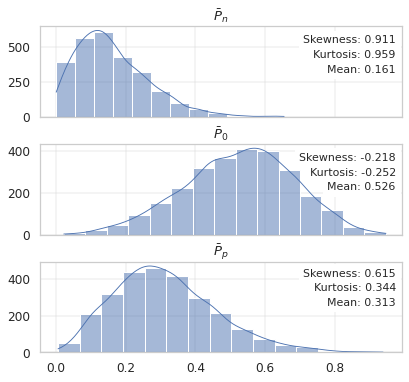

In [ ]:
sns.set(rc={'figure.figsize':(6.5,6), "lines.linewidth": 0.9, "grid.linewidth": 0.4}, font_scale=1.1)
sns.set_style("whitegrid")

f, (ax_neg, ax_neu, ax_pos) = plt.subplots(3, sharex=True)
f.subplots_adjust(hspace=.3)

sns.histplot(x='NEG', data=df_sentiment, color="b", bins=12, kde=True, ax=ax_neg)
sns.histplot(x='NEU', data=df_sentiment, color="b", bins=15, kde=True, ax=ax_neu)
sns.histplot(x='POS', data=df_sentiment, color="b", bins=15, kde=True, ax=ax_pos)

ax_neg.set(ylabel='')
ax_neg.set_title(r'$\bar{P}_{n}$')
ax_neg.text(x=.93, y=1.46, transform=fig.transAxes, s="Skewness: %.3f" % df_sentiment['NEG'].skew(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')
ax_neg.text(x=.93, y=1.39, transform=fig.transAxes, s="Kurtosis: %.3f" % df_sentiment['NEG'].kurt(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')
ax_neg.text(x=.93, y=1.32, transform=fig.transAxes, s="Mean: %.3f" % df_sentiment['NEG'].mean(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')

ax_neu.set(ylabel='')
ax_neu.set_title(r'$\bar{P}_{0} $')
ax_neu.text(x=.93, y=.9, transform=fig.transAxes, s="Skewness: %.3f" % df_sentiment['NEU'].skew(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')
ax_neu.text(x=.93, y=.83, transform=fig.transAxes, s="Kurtosis: %.3f" % df_sentiment['NEU'].kurt(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')
ax_neu.text(x=.93, y=.76, transform=fig.transAxes, s="Mean: %.3f" % df_sentiment['NEU'].mean(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')

ax_pos.set(ylabel='', xlabel='')
ax_pos.set_title(r'$\bar{P}_{p} $')
ax_pos.text(x=.93, y=.35, transform=fig.transAxes, s="Skewness: %.3f" % df_sentiment['POS'].skew(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')
ax_pos.text(x=.93, y=.28, transform=fig.transAxes, s="Kurtosis: %.3f" % df_sentiment['POS'].kurt(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')
ax_pos.text(x=.93, y=.21, transform=fig.transAxes, s="Mean: %.3f" % df_sentiment['POS'].mean(),\
        fontsize=11, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white')

plt.show()

In [ ]:
df_sentiment['SentimentLabel'].value_counts()

POS    2128
NEG     554
Name: SentimentLabel, dtype: int64

In [ ]:
fig_age1 = px.histogram(
    df_sentiment, 
    x = 'SentimentLabel', 
    histnorm = 'percent',
    category_orders = {
        'Rating': ['verde', 'giallo', 'arancione', 'rosso']
    },
    color = 'Rating', 
    barmode = 'group',
    color_discrete_map={
        'verde': '#b0d8a4',
        'giallo': '#fee191',
        'arancione' : '#fd8060', 
        'rosso'  : '#e84258'
    }
) 

fig_age1.update_layout(
    title_text='Distribution of SentimentLabel and Rating',
    xaxis_title_text='', # xaxis label
    #yaxis_title_text='Count', # yaxis label
    bargap = 0.1, # gap between bars of adjacent location coordinates
    bargroupgap = 0.1, # gap between bars of the same location coordinates
    width=500, height=400,
    legend = dict(
      orientation="h",
      yanchor="top",
      xanchor="right",
      x=1
    )
)

fig_age1.show()

In [ ]:
fig = px.strip(df_sentiment, x="Rating", y="SentimentScore", color='Rating',
                 category_orders = {
                    'Rating': ['verde', 'giallo', 'arancione', 'rosso']
                },
                 color_discrete_map={
                    'verde': '#b0d8a4',
                    'giallo': '#fee191',
                    'arancione' : '#fd8060', 
                    'rosso'  : '#e84258'
                }
    )

fig.update_layout(
    title_text='Distribution of SentimentScore and Rating', 
    xaxis_title_text='', # xaxis label
    #yaxis_title_text='Count', # yaxis label
    bargap = 0.1, # gap between bars of adjacent location coordinates
    bargroupgap = 0.1, # gap between bars of the same location coordinates
    width=500, height=400,
    legend = dict(
      orientation="h",
      yanchor="top",
      xanchor="right",
      x=1
    )
)
fig.show()

In [ ]:
fig_age1 = px.histogram(
    df_sentiment, 
    histnorm = 'percent',
    x = 'SentimentLabel', 
    color = 'Popularity', 
    barmode = 'group',
    category_orders = {
        'Popularity': ['unpopular', 'medium', 'popular']
    },
    color_discrete_map={  
        'popular': '#f6b969',
        'medium': '#f99c93',
        'unpopular' : '#b57db3', 
    }
) 

fig_age1.update_layout(
    title_text='Distribution of SentimentLabel and Popularity', 
    xaxis_title_text='', # xaxis label
    #yaxis_title_text='Count', # yaxis label
    bargap = 0.1, # gap between bars of adjacent location coordinates
    bargroupgap = 0.1, # gap between bars of the same location coordinates
    width=500, height=400,
    legend = dict(
      orientation="h",
      yanchor="top",
      xanchor="right",
      x=1
    )
)

fig_age1.show()

In [ ]:
fig = px.scatter(df_sentiment, x="N_Rev", y="SentimentScore", color='Popularity',
                color_discrete_map={  
                  'popular': '#f6b969',
                  'medium': '#f99c93',
                  'unpopular' : '#b57db3'
                  }
                 )

fig.update_layout(
    title_text='Distribution of Sentiment Score and Number of reviews', 
    #xaxis_title_text='', # xaxis label
    #yaxis_title_text='', # yaxis label
    bargap = 0.1, # gap between bars of adjacent location coordinates
    bargroupgap = 0.1, # gap between bars of the same location coordinates
    width=500, height=400,
    legend = dict(
      orientation="h",
      yanchor="bottom",
      y=-.35,
      xanchor="right",
      x=1
      )
)
fig.show()

## Spearman: SentimentScore e N_Tot_Rec numerico, SentimentScore e Rating (0 - 1 - 2 - 3)

In [ ]:
stats.spearmanr(df_sentiment['SentimentScore'], df_sentiment['N_Rev'])

SpearmanrResult(correlation=0.033561243205735135, pvalue=0.0822548876064535)

In [ ]:
stats.spearmanr(df_sentiment['SentimentScore'], df_sentiment['N_Rating'])

SpearmanrResult(correlation=-0.04734862841813085, pvalue=0.014193660662889235)

#Time Series Analysis

In [ ]:
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.clustering import TimeSeriesKMeans

from sklearn.metrics import silhouette_score

In [ ]:
ts_df = pd.DataFrame(df_sentiment['TS'].to_list(), index=df_sentiment.index)

In [ ]:
ts_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
5,0.971398,0.976778,0.000000,0.000000,-0.961567,0.000000,0.000000,-0.976836,0.000000,-0.949794,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.828364,0.965355,NaN,NaN,NaN
13,0.996743,-0.732792,-0.905700,-0.995538,0.000000,0.990315,0.972336,0.794466,0.971846,0.000000,0.994012,0.000000,0.0,0.983706,0.934502,0.995463,0.996246,0.998687,-0.810504,0.000000,0.990129,0.998459,0.995502,-0.828913,0.0
17,0.000000,0.000000,0.953252,0.000000,0.000000,0.981092,0.000000,0.000000,0.939843,0.000000,0.841002,0.000000,0.0,0.000000,0.980724,0.000000,0.000000,0.996376,0.881882,0.000000,0.000000,NaN,NaN,NaN,NaN
34,0.000000,0.000000,0.000000,0.985201,-0.994298,0.000000,0.000000,0.000000,0.000000,0.000000,0.906076,0.000000,0.0,0.000000,0.000000,-0.678411,0.361686,0.000000,0.000000,0.952256,0.000000,NaN,NaN,NaN,NaN
38,0.000000,0.000000,0.000000,-0.970769,-0.679548,0.000000,0.000000,0.000000,0.983350,-0.894015,0.000000,0.925782,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990331,0.000000,NaN


In [ ]:
ndfts = df.join(ts_df, how='right')
ndfts.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev,Popularity,N_Sent,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2,unpopular,22,0.649392,0.649392,0.649392,0.325593,-0.320522,-0.320522,-0.320522,-0.325612,-0.325612,-0.642210,-0.316598,-0.316598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.276121,0.597906,0.597906,0.597906,0.597906
13,80,Semplicemente..grazie.,verde,Kiara,2003-06-21 00:00:00+00:00,1,Semplicemente Semplicemente..grazie...,27,popular,25,-0.213916,-0.213916,-0.213916,-0.878010,-0.633746,-0.001741,0.654217,0.919039,0.912883,0.588771,0.655286,0.331337,0.331337,0.327902,0.639403,0.971224,0.975404,0.996798,0.394809,0.062728,0.059875,0.662863,0.994697,0.388349,0.055530
17,706259,Mille papaveri rossi.,verde,Hayley Black,2011-01-05 00:00:00+00:00,1,Mille papaveri rossi. Dormi sepolto in ...,8,popular,21,0.317751,0.317751,0.317751,0.317751,0.317751,0.327031,0.327031,0.327031,0.313281,0.313281,0.593615,0.280334,0.280334,0.000000,0.326908,0.326908,0.326908,0.332125,0.626086,0.626086,0.293961,0.293961,0.293961,0.293961,0.293961
34,719014,Heartbreak,giallo,Emily Kingston,2011-05-20 00:00:00+00:00,1,"Heartbreak Tic, toc. Tic, toc. Il tu...",4,medium,21,0.000000,0.000000,0.000000,0.328400,-0.003032,-0.003032,-0.331433,0.000000,0.000000,0.000000,0.302025,0.302025,0.302025,0.000000,0.000000,-0.226137,-0.105575,-0.105575,0.120562,0.317419,0.317419,0.317419,0.317419,0.317419,0.317419
38,719165,Un amore felino,verde,WhitePumpkin,2011-05-20 00:00:00+00:00,1,"Mrs Purr correva per i corridoi di Hogwarts, g...",3,medium,24,0.000000,0.000000,0.000000,-0.323590,-0.550106,-0.550106,-0.226516,0.000000,0.327783,0.029778,0.029778,0.010589,0.308594,0.308594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330110,0.330110,0.330110


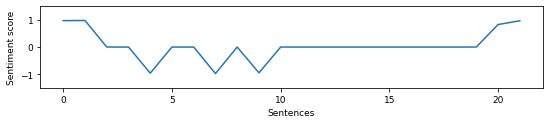

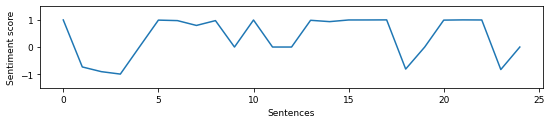

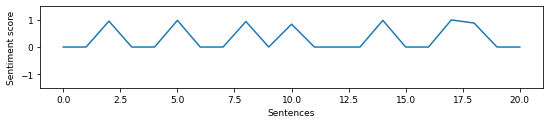

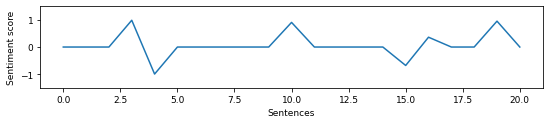

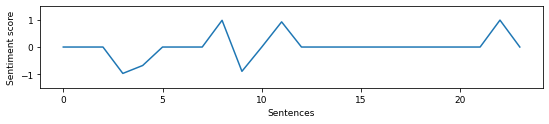

In [ ]:
for i in range(len(ts_df.head())):
  plt.figure(figsize=(9, 1.5))
  plt.ylabel('Sentiment score', fontsize=9)
  plt.yticks(fontsize=9)
  plt.xlabel('Sentences', fontsize=9)
  plt.xticks(fontsize=9)
  ts_df.iloc[i].plot()
  plt.ylim([-1.5, 1.5])

In [ ]:
# apply moving average to dataset
w = 3
for i in range(ts_df.shape[0]):
  #ts_df.iloc[i,:] = (ts_df.iloc[i,:] - ts_df.iloc[i,:].mean()/ts_df.iloc[i,:].std()).rolling(window=w).mean()
  ts_df.iloc[i,:] = (ts_df.iloc[i,:]).rolling(window=w).mean()

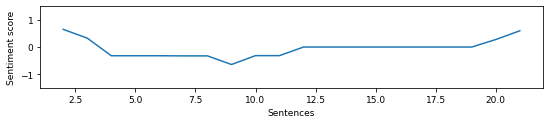

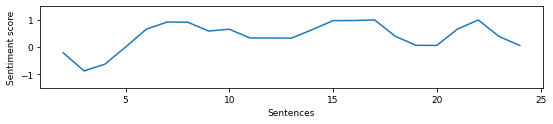

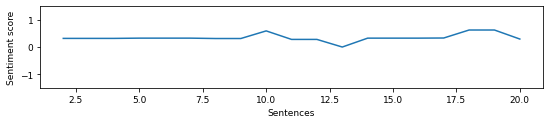

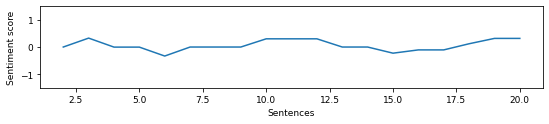

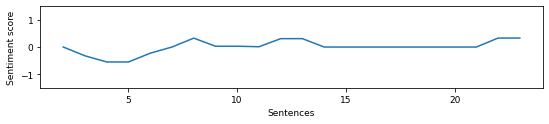

In [ ]:
for i in range(len(ts_df.head())):
  plt.figure(figsize=(9, 1.5))
  plt.ylabel('Sentiment score', fontsize=9)
  plt.yticks(fontsize=9)
  plt.xlabel('Sentences', fontsize=9)
  plt.xticks(fontsize=9)
  ts_df.iloc[i].plot()
  plt.ylim([-1.5, 1.5])

In [ ]:
ts_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
5,NaN,NaN,0.649392,0.325593,-0.320522,-0.320522,-0.320522,-0.325612,-0.325612,-0.642210,-0.316598,-0.316598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.276121,0.597906,NaN,NaN,NaN
13,NaN,NaN,-0.213916,-0.878010,-0.633746,-0.001741,0.654217,0.919039,0.912883,0.588771,0.655286,0.331337,0.331337,0.327902,0.639403,0.971224,0.975404,0.996798,0.394809,0.062728,0.059875,0.662863,0.994697,0.388349,0.05553
17,NaN,NaN,0.317751,0.317751,0.317751,0.327031,0.327031,0.327031,0.313281,0.313281,0.593615,0.280334,0.280334,0.000000,0.326908,0.326908,0.326908,0.332125,0.626086,0.626086,0.293961,NaN,NaN,NaN,NaN
34,NaN,NaN,0.000000,0.328400,-0.003032,-0.003032,-0.331433,0.000000,0.000000,0.000000,0.302025,0.302025,0.302025,0.000000,0.000000,-0.226137,-0.105575,-0.105575,0.120562,0.317419,0.317419,NaN,NaN,NaN,NaN
38,NaN,NaN,0.000000,-0.323590,-0.550106,-0.550106,-0.226516,0.000000,0.327783,0.029778,0.029778,0.010589,0.308594,0.308594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330110,0.330110,NaN


Fill nans

In [ ]:
ts_df[0].fillna(ts_df[2], inplace=True)
ts_df[1].fillna(ts_df[2], inplace=True)

for i in range(19, 24):
  ts_df[i+1].fillna(ts_df[i], inplace=True)

ts_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
5,0.649392,0.649392,0.649392,0.325593,-0.320522,-0.320522,-0.320522,-0.325612,-0.325612,-0.642210,-0.316598,-0.316598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.276121,0.597906,0.597906,0.597906,0.597906
13,-0.213916,-0.213916,-0.213916,-0.878010,-0.633746,-0.001741,0.654217,0.919039,0.912883,0.588771,0.655286,0.331337,0.331337,0.327902,0.639403,0.971224,0.975404,0.996798,0.394809,0.062728,0.059875,0.662863,0.994697,0.388349,0.055530
17,0.317751,0.317751,0.317751,0.317751,0.317751,0.327031,0.327031,0.327031,0.313281,0.313281,0.593615,0.280334,0.280334,0.000000,0.326908,0.326908,0.326908,0.332125,0.626086,0.626086,0.293961,0.293961,0.293961,0.293961,0.293961
34,0.000000,0.000000,0.000000,0.328400,-0.003032,-0.003032,-0.331433,0.000000,0.000000,0.000000,0.302025,0.302025,0.302025,0.000000,0.000000,-0.226137,-0.105575,-0.105575,0.120562,0.317419,0.317419,0.317419,0.317419,0.317419,0.317419
38,0.000000,0.000000,0.000000,-0.323590,-0.550106,-0.550106,-0.226516,0.000000,0.327783,0.029778,0.029778,0.010589,0.308594,0.308594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330110,0.330110,0.330110


In [ ]:
# SAX transform
n_paa_segments = 25
n_sax_symbols = 21
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts_df)
sax_dataset_inv = sax.inverse_transform(ts_sax) 

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 2682 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


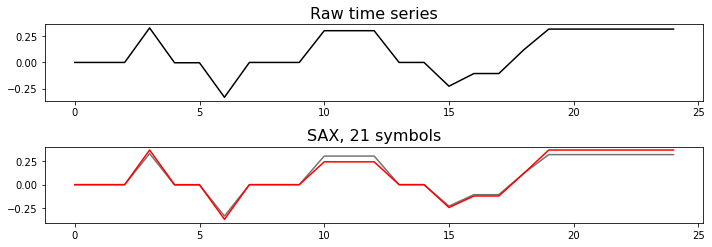

In [ ]:
# PLOTTING FIRST TRACK 
plt.figure(figsize=(10,5))
l=3
plt.subplot(3, 1, 1)  # First, raw time series
plt.plot(ts_df.iloc[l,:].ravel(), c="black")
plt.title("Raw time series", fontsize=16)

plt.subplot(3, 1, 2)  # Then SAX
plt.plot(ts_df.iloc[l,:].ravel(), c="black", alpha=0.55)
#plt.xlim(2.5, 20)
plt.plot(sax_dataset_inv[l].ravel(), c='red')
plt.title("SAX, %d symbols" % n_sax_symbols, fontsize=16)

plt.tight_layout()

In [ ]:
n_paa_segments = 25
n_sax_symbols = 21
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts_df)
ts_sax_inv = sax.inverse_transform(ts_sax)
ts_sax = ts_sax.squeeze()
df_sax = pd.DataFrame(ts_sax, index=ts_df.index)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 2682 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [ ]:
df_sax.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
5,15,15,15,13,7,7,7,7,7,5,7,7,10,10,10,10,10,10,10,10,12,15,15,15,15
13,8,8,8,3,5,10,15,17,17,15,15,13,13,13,15,17,17,17,13,11,11,15,17,13,10
17,13,13,13,13,13,13,13,13,13,13,15,12,12,10,13,13,13,13,15,15,12,12,12,12,12
34,10,10,10,13,10,10,7,10,10,10,12,12,12,10,10,8,9,9,11,13,13,13,13,13,13
38,10,10,10,7,6,6,8,10,13,10,10,10,13,13,10,10,10,10,10,10,10,10,13,13,13


In [ ]:
df_sax_norm = (df_sax - 10) * 0.1
df_sax_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
5,0.5,0.5,0.5,0.3,-0.3,-0.3,-0.3,-0.3,-0.3,-0.5,-0.3,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.5,0.5,0.5,0.5
13,-0.2,-0.2,-0.2,-0.7,-0.5,0.0,0.5,0.7,0.7,0.5,0.5,0.3,0.3,0.3,0.5,0.7,0.7,0.7,0.3,0.1,0.1,0.5,0.7,0.3,0.0
17,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.5,0.2,0.2,0.0,0.3,0.3,0.3,0.3,0.5,0.5,0.2,0.2,0.2,0.2,0.2
34,0.0,0.0,0.0,0.3,0.0,0.0,-0.3,0.0,0.0,0.0,0.2,0.2,0.2,0.0,0.0,-0.2,-0.1,-0.1,0.1,0.3,0.3,0.3,0.3,0.3,0.3
38,0.0,0.0,0.0,-0.3,-0.4,-0.4,-0.2,0.0,0.3,0.0,0.0,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3,0.3


# Clustering

## Elbow method

In [ ]:
# computing optimal number of clusters
sse_sax=[]
sil_sax=[]

max_k=30
for k in tqdm(range(2, max_k+1)):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric='euclidean', max_iter=20, random_state=42, n_jobs=-1)
    kmeans.fit(df_sax)
    sil = silhouette_score(df_sax, kmeans.labels_)
    sse = kmeans.inertia_
    sil_sax.append(sil)
    sse_sax.append(sse)

100%|██████████| 29/29 [02:29<00:00,  5.17s/it]


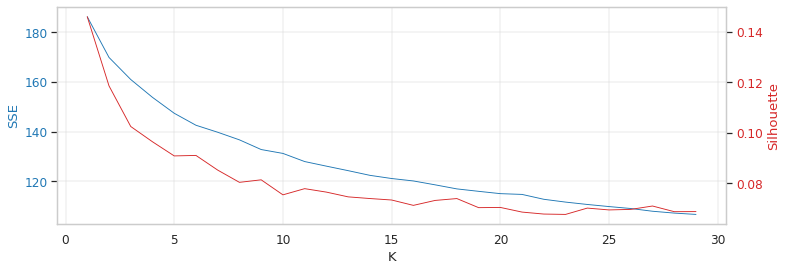

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,4))
t = np.arange(1,30,1)
color='tab:blue'
ax1.set_ylabel("SSE", color=color)
ax1.set_xlabel('K')
ax1.plot(t, sse_sax, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
ax2.grid(False)
color = 'tab:red'
ax2.set_ylabel('Silhouette', color=color)
ax2.plot(t, sil_sax, color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [ ]:
# computing optimal number of clusters (DTW)
sse_sax=[]
sil_sax=[]

max_k = 30
for k in tqdm(range(2, max_k+1)):
    kmeans = TimeSeriesKMeans(n_clusters = k, metric = 'dtw', max_iter = 20, random_state = 42, n_jobs = mm-1)
    kmeans.fit(df_sax)
    sil = silhouette_score(df_sax, kmeans.labels_)
    sse = kmeans.inertia_
    sil_sax.append(sil)
    sse_sax.append(sse)

100%|██████████| 29/29 [2:54:57<00:00, 361.98s/it]


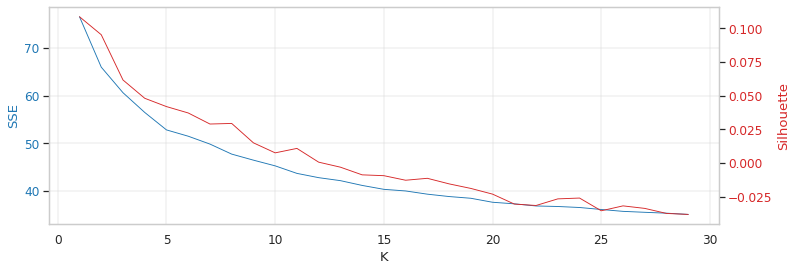

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,4))
t = np.arange(1,30,1)
color='tab:blue'
ax1.set_ylabel("SSE", color=color)
ax1.set_xlabel('K')
ax1.plot(t, sse_sax, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
ax2.grid(False)

color = 'tab:red'
ax2.set_ylabel('Silhouette', color=color)
ax2.plot(t, sil_sax, color=color)
ax2.tick_params(axis='y', labelcolor=color)

## K-means 

In [ ]:
def get_info(km, df_all, df):

  info = {}
  
  for i in range(len(km.cluster_centers_)):
    info[i] = {}
    info[i]['size'] = sum(km.labels_ == i)

    dict_rating = dict(df_all[km.labels_ == i]['Rating'].value_counts(normalize=True))
    dict_rating_n = dict(df_all[km.labels_ == i]['Rating'].value_counts())

    for l in dict(df_all['Rating'].value_counts(normalize=True)):
      info[i][l] = dict_rating[l]
      info[i]['%'+l] = dict_rating_n[l]/sum(df_all['Rating']==l)*100
    
    dict_popularity = dict(df_all[km.labels_ == i]['Popularity'].value_counts(normalize=True))
    dict_popularity_n = dict(df_all[km.labels_ == i]['Popularity'].value_counts())

    for l in dict(df_all['Popularity'].value_counts(normalize=True)):
      info[i][l] = dict_popularity[l]
      info[i]['%'+l] = dict_popularity_n[l]/sum(df_all['Popularity']==l)*100

  print(f"SSE:\t {round(km.inertia_,3)}")
  print(f"Silhouette score:\t {round(silhouette_score(df, km.labels_),3)}")

  info = pd.DataFrame.from_dict(info).round(2).T

  column_names = ['size', 
                  'verde','giallo','arancione','rosso',
                  '%verde','%giallo','%arancione','%rosso',
                  'unpopular','medium','popular',
                  '%unpopular','%medium','%popular']

  info = info.reindex(columns=column_names)

  return info

In [ ]:
def plot_km(km, df):
  n = len(km.cluster_centers_)
  m = int(np.ceil(n/2))
  fig, axes = plt.subplots(m, 2, figsize=(9, 2.5*m))

  for i in range(len(km.cluster_centers_)):
    ax = axes.flat[i]
    ax.set_title(f'CLUSTER {i} - size: {sum(km.labels_ == i)}')
    ax.plot(np.squeeze(df[km.labels_ == i]).T,color='black', alpha=0.01)
    ax.plot(np.squeeze(km.cluster_centers_[i]).T, color='red', linewidth=4)
    
  if(n%2!=0):
    axes[m-1][1].set_visible(False)

  fig.tight_layout()
  plt.show()

### EUCLIDEAN - 4 CLUSTERS

In [ ]:
km4_eu = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=100, random_state=42)
km4_eu.fit(df_sax)

TimeSeriesKMeans(max_iter=100, n_clusters=4, random_state=42)

In [ ]:
info_km4_eu = get_info(km4_eu, ndfts, df_sax)
info_km4_eu

SSE:	 161.011
Silhouette score:	 0.103


,size,verde,giallo,arancione,rosso,%verde,%giallo,%arancione,%rosso,unpopular,medium,popular,%unpopular,%medium,%popular
0,595.0,0.81,0.12,0.05,0.02,22.73,17.5,27.62,25.00,0.41,0.37,0.22,21.93,23.96,20.15
1,782.0,0.76,0.18,0.04,0.02,28.01,35.5,31.43,23.21,0.45,0.31,0.24,31.50,26.48,28.94
2,690.0,0.80,0.14,0.04,0.02,26.17,24.0,23.81,25.00,0.41,0.34,0.26,25.36,25.38,26.82
3,615.0,0.80,0.15,0.03,0.02,23.10,23.0,17.14,26.79,0.38,0.36,0.26,21.21,24.18,24.09


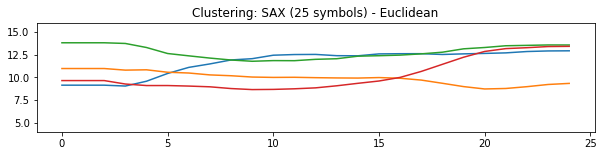

In [ ]:
plt.figure(figsize=(10,2))
plt.title('Clustering: SAX (25 symbols) - Euclidean')
plt.plot(np.squeeze(km4_eu.cluster_centers_).T)
plt.ylim([4,16])
plt.show()

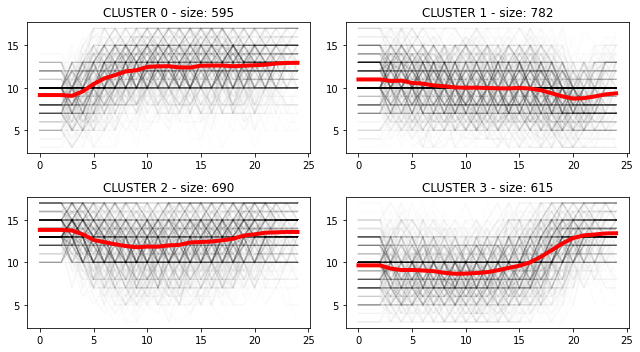

In [ ]:
plot_km(km4_eu, df_sax)

## EUCLIDEAN - 5 CLUSTERS

In [ ]:
km5_eu = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=100, random_state=42)
km5_eu.fit(df_sax)

TimeSeriesKMeans(max_iter=100, n_clusters=5, random_state=42)

In [ ]:
info_km5_eu = get_info(km5_eu, ndfts, df_sax)
info_km5_eu

SSE:	 152.295
Silhouette score:	 0.1


,size,verde,giallo,arancione,rosso,%verde,%giallo,%arancione,%rosso,unpopular,medium,popular,%unpopular,%medium,%popular
0,547.0,0.79,0.16,0.03,0.03,20.41,21.25,14.29,25.00,0.37,0.39,0.25,18.05,23.09,20.61
1,554.0,0.76,0.17,0.04,0.03,19.75,23.75,21.90,30.36,0.44,0.31,0.25,21.75,18.93,21.21
2,424.0,0.83,0.11,0.03,0.02,16.69,12.00,13.33,14.29,0.42,0.34,0.24,15.97,15.75,15.61
3,553.0,0.77,0.17,0.05,0.01,20.08,23.75,25.71,8.93,0.43,0.32,0.25,21.30,19.26,21.36
4,604.0,0.81,0.13,0.04,0.02,23.06,19.25,24.76,21.43,0.42,0.35,0.23,22.92,22.98,21.21


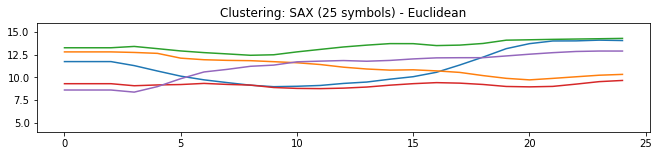

In [ ]:
plt.figure(figsize=(11,2))
plt.title('Clustering: SAX (25 symbols) - Euclidean')
plt.plot(np.squeeze(km5_eu.cluster_centers_).T)
plt.ylim([4,16])
plt.show()

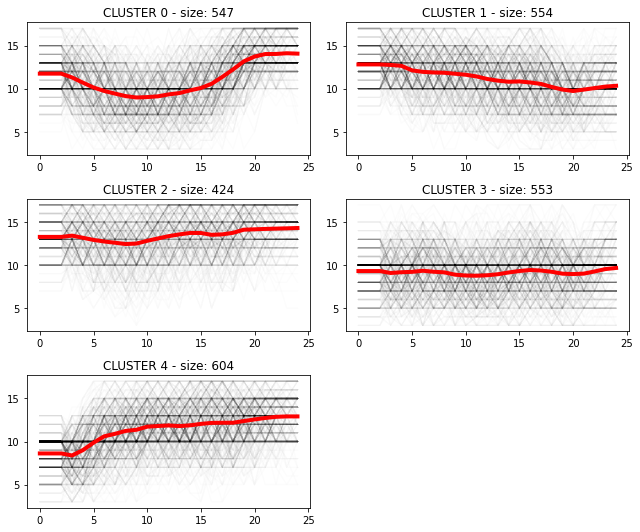

In [ ]:
plot_km(km5_eu, df_sax)

## DTW - 4 CLUSTERS

In [ ]:
km4_dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=100, random_state=42, n_jobs=-1)
km4_dtw.fit(df_sax)

TimeSeriesKMeans(max_iter=100, metric='dtw', n_clusters=4, n_jobs=-1,
                 random_state=42)

In [ ]:
info_km4_dtw = get_info(km4_dtw, ndfts, df_sax)
info_km4_dtw

SSE:	 60.603
Silhouette score:	 0.062


,size,verde,giallo,arancione,rosso,%verde,%giallo,%arancione,%rosso,unpopular,medium,popular,%unpopular,%medium,%popular
0,724.0,0.80,0.14,0.04,0.02,27.16,26.00,29.52,23.21,0.41,0.33,0.26,26.71,26.37,28.33
1,687.0,0.76,0.18,0.04,0.02,24.75,30.25,27.62,21.43,0.44,0.32,0.23,27.53,24.18,24.39
2,647.0,0.82,0.12,0.04,0.02,24.94,20.00,21.90,26.79,0.38,0.38,0.24,21.93,27.13,23.64
3,624.0,0.79,0.15,0.04,0.03,23.15,23.75,20.95,28.57,0.42,0.33,0.25,23.83,22.32,23.64


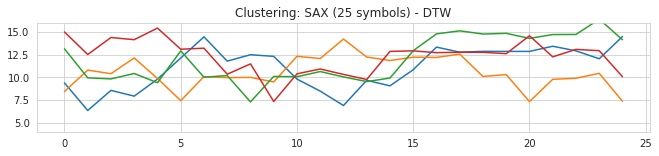

In [ ]:
plt.figure(figsize=(11,2))
plt.title('Clustering: SAX (25 symbols) - DTW')
plt.plot(np.squeeze(km4_dtw.cluster_centers_).T)
plt.ylim([4,16])
plt.show()

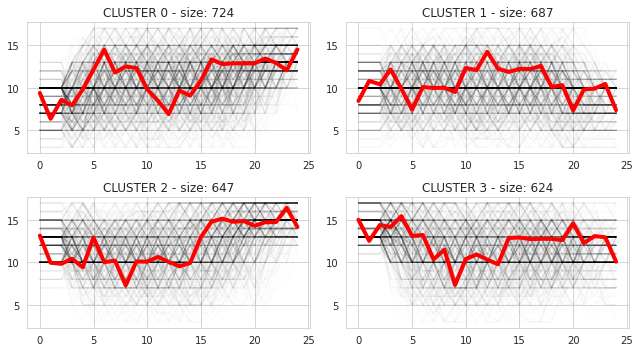

In [ ]:
plot_km(km4_dtw, df_sax)

## DTW - 5 CLUSTERS

In [ ]:
km5_dtw = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=100, random_state=42, n_jobs=-1)
km5_dtw.fit(df_sax)

TimeSeriesKMeans(max_iter=100, metric='dtw', n_clusters=5, n_jobs=-1,
                 random_state=42)

In [ ]:
info_km5_dtw = get_info(km5_dtw, ndfts, df_sax)
info_km5_dtw

SSE:	 56.474
Silhouette score:	 0.048


,size,verde,giallo,arancione,rosso,%verde,%giallo,%arancione,%rosso,unpopular,medium,popular,%unpopular,%medium,%popular
0,464.0,0.81,0.13,0.04,0.01,17.77,15.25,19.05,10.71,0.42,0.33,0.25,17.51,16.96,17.42
1,626.0,0.75,0.18,0.04,0.03,22.02,28.75,25.71,30.36,0.42,0.32,0.27,23.56,21.66,25.30
2,606.0,0.83,0.12,0.03,0.02,23.67,18.00,16.19,26.79,0.39,0.38,0.23,21.12,25.16,21.52
3,526.0,0.80,0.14,0.04,0.02,19.75,18.50,20.95,19.64,0.40,0.35,0.25,19.04,19.91,20.15
4,460.0,0.77,0.17,0.04,0.02,16.78,19.50,18.10,12.50,0.45,0.32,0.22,18.77,16.30,15.61


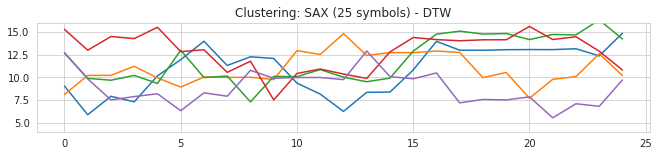

In [ ]:
plt.figure(figsize=(11,2))
plt.title('Clustering: SAX (25 symbols) - DTW')
plt.plot(np.squeeze(km5_dtw.cluster_centers_).T)
plt.ylim([4,16])
plt.show()

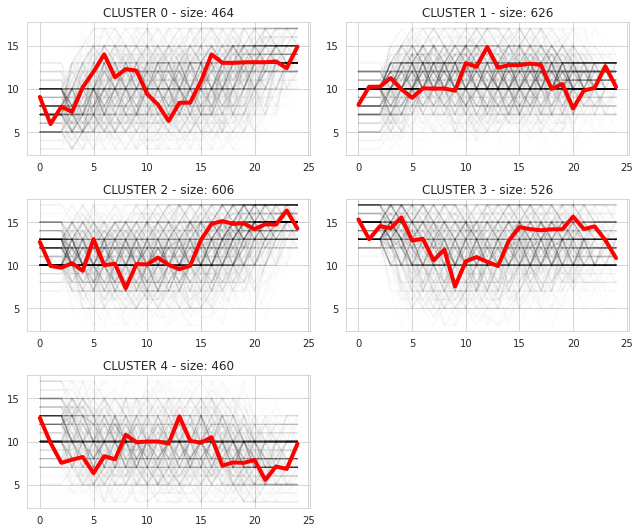

In [ ]:
plot_km(km5_dtw, df_sax)

## DTW - SAKOE BAND - 4 CLUSTERS

In [ ]:
km4_scband = TimeSeriesKMeans(n_clusters=4, metric="dtw", metric_params= {"global_constraint":"sakoe_chiba"}, 
                             max_iter=100, random_state=42, n_jobs=-1)
km4_scband.fit(df_sax)

TimeSeriesKMeans(max_iter=100, metric='dtw',
                 metric_params={'global_constraint': 'sakoe_chiba'},
                 n_clusters=4, n_jobs=-1, random_state=42)

In [ ]:
info_km4_scband = get_info(km4_scband, ndfts, df_sax)
info_km4_scband

SSE:	 133.465
Silhouette score:	 0.089


,size,verde,giallo,arancione,rosso,%verde,%giallo,%arancione,%rosso,unpopular,medium,popular,%unpopular,%medium,%popular
0,621.0,0.76,0.18,0.04,0.02,22.40,27.25,22.86,23.21,0.44,0.32,0.24,24.64,21.99,22.27
1,632.0,0.78,0.17,0.04,0.02,23.10,26.75,22.86,19.64,0.44,0.31,0.25,24.91,21.44,24.24
2,718.0,0.82,0.13,0.03,0.02,27.72,22.75,21.90,28.57,0.37,0.38,0.25,24.28,29.54,27.12
3,711.0,0.80,0.13,0.05,0.02,26.78,23.25,32.38,28.57,0.41,0.35,0.24,26.17,27.02,26.36


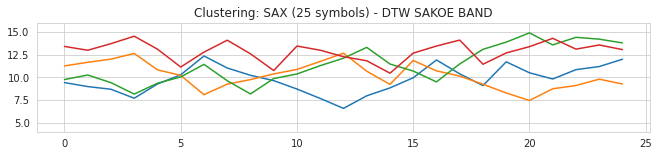

In [ ]:
plt.figure(figsize=(11,2))
plt.title('Clustering: SAX (25 symbols) - DTW SAKOE BAND')
plt.plot(np.squeeze(km4_scband.cluster_centers_).T)
plt.ylim([4,16])
plt.show()

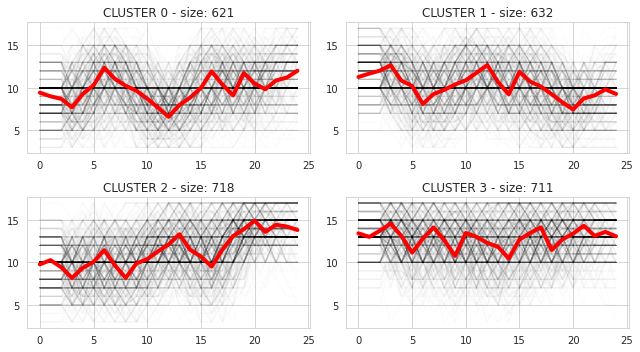

In [ ]:
plot_km(km4_scband, df_sax)

## DTW - SAKOE BAND - 5 CLUSTERS

In [ ]:
km5_scband = TimeSeriesKMeans(n_clusters=5, metric="dtw", metric_params= {"global_constraint":"sakoe_chiba"}, 
                             max_iter=100, random_state=42, n_jobs=-1)
km5_scband.fit(df_sax)

TimeSeriesKMeans(max_iter=100, metric='dtw',
                 metric_params={'global_constraint': 'sakoe_chiba'},
                 n_clusters=5, n_jobs=-1, random_state=42)

In [ ]:
info_km5_scband = get_info(km5_scband, ndfts, df_sax)
info_km5_scband

SSE:	 125.751
Silhouette score:	 0.086


,size,verde,giallo,arancione,rosso,%verde,%giallo,%arancione,%rosso,unpopular,medium,popular,%unpopular,%medium,%popular
0,527.0,0.76,0.18,0.04,0.02,18.76,24.00,21.90,17.86,0.43,0.31,0.25,20.67,17.94,20.30
1,574.0,0.78,0.17,0.03,0.02,21.12,24.00,17.14,21.43,0.44,0.30,0.26,22.74,19.15,22.27
2,629.0,0.82,0.13,0.04,0.02,24.28,20.00,21.90,19.64,0.37,0.38,0.26,20.76,25.93,24.55
3,491.0,0.79,0.14,0.05,0.02,18.39,17.25,21.90,16.07,0.40,0.37,0.23,17.87,19.80,16.97
4,461.0,0.80,0.13,0.04,0.03,17.44,14.75,17.14,25.00,0.43,0.34,0.23,17.96,17.18,15.91


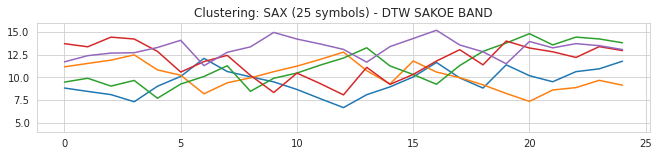

In [ ]:
plt.figure(figsize=(11,2))
plt.title('Clustering: SAX (25 symbols) - DTW SAKOE BAND')
plt.plot(np.squeeze(km5_scband.cluster_centers_).T)
plt.ylim([4,16])
plt.show()

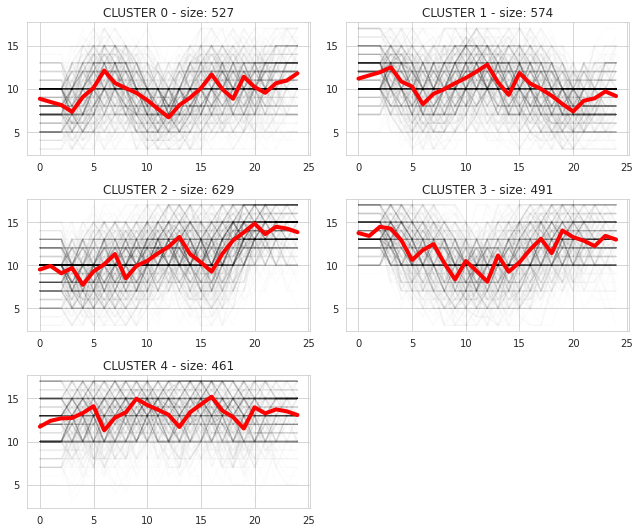

In [ ]:
plot_km(km5_scband, df_sax)